In [1]:
import xarray as xr

# Load the NetCDF file
file_path = "datos/Land_and_Ocean_EqualArea.nc"
data = xr.open_dataset(file_path)

# Display the structure of the dataset
data_structure = data.info()
data_structure



xarray.Dataset {
dimensions:
	map_points = 15984 ;
	time = 2089 ;
	month_number = 12 ;

variables:
	float32 longitude(map_points) ;
		longitude:units = degrees_east ;
		longitude:standard_name = longitude ;
		longitude:long_name = Longitude ;
	float32 latitude(map_points) ;
		latitude:units = degrees_north ;
		latitude:standard_name = latitude ;
		latitude:long_name = Latitude ;
	float64 time(time) ;
		time:units = year A.D. ;
		time:standard_name = time ;
		time:long_name = Time ;
	float64 land_mask(map_points) ;
		land_mask:units = none ;
		land_mask:standard_name = land_mask ;
		land_mask:long_name = Land Mask ;
		land_mask:valid_min = 0.0 ;
		land_mask:valid_max = 1.0 ;
	float32 temperature(time, map_points) ;
		temperature:units = degree C ;
		temperature:standard_name = surface_temperature_anomaly ;
		temperature:long_name = Air Surface Temperature Anomaly ;
		temperature:valid_min = -17.581396970370164 ;
		temperature:valid_max = 23.203125874201458 ;
	float32 climatology(month_n

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter

# Extract latitude, longitude, and temperature data
latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature = data['temperature'].values

# Reshape the data to a grid-like structure for convolution
# Assume that map_points can be structured into a grid, if not, interpolation might be required

# Applying a Gaussian filter (convolution) to the temperature data
# The sigma value determines the amount of smoothing
temperature_smoothed = gaussian_filter(temperature, sigma=1, mode='nearest')

# Example: Checking the shape of the smoothed data and the first few values
temperature_smoothed_shape = temperature_smoothed.shape
temperature_smoothed_sample = temperature_smoothed[0, :5]

temperature_smoothed_shape, temperature_smoothed_sample


((2089, 15984), array([nan, nan, nan, nan, nan], dtype=float32))

In [3]:
# Interpolation of NaN values in the temperature data
temperature_interpolated = np.copy(temperature)

# Using numpy's interpolation function, but first we need to deal with NaN values
for i in range(temperature_interpolated.shape[0]):
    # Interpolating along the map_points dimension (latitude-longitude)
    nan_mask = np.isnan(temperature_interpolated[i])
    valid_mask = ~nan_mask
    
    if valid_mask.sum() > 0:  # Ensure there are valid points to interpolate
        temperature_interpolated[i, nan_mask] = np.interp(
            np.flatnonzero(nan_mask),
            np.flatnonzero(valid_mask),
            temperature_interpolated[i, valid_mask]
        )

# Apply the Gaussian filter (convolution) again to the interpolated data
temperature_smoothed_interpolated = gaussian_filter(temperature_interpolated, sigma=3, mode='nearest')

# Checking the shape of the smoothed data and the first few values after interpolation and smoothing
temperature_smoothed_shape_after_interpolation = temperature_smoothed_interpolated.shape
temperature_smoothed_sample_after_interpolation = temperature_smoothed_interpolated[0, :5]

temperature_smoothed_shape_after_interpolation, temperature_smoothed_sample_after_interpolation


((2089, 15984),
 array([-0.03094883, -0.02777315, -0.02193933, -0.0124544 ,  0.00109062],
       dtype=float32))

Número de puntos visualizados: 15984


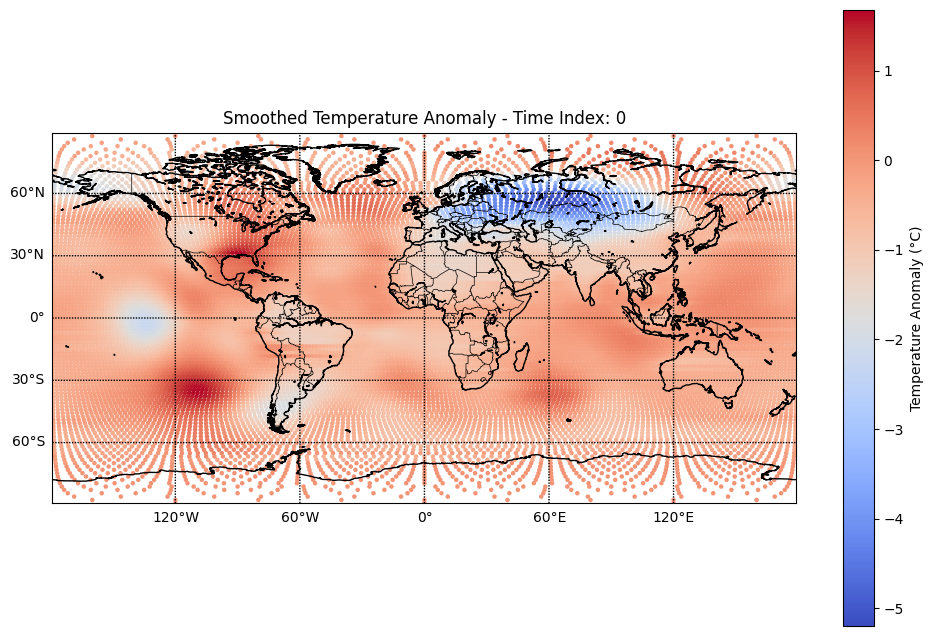

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Seleccionar un tiempo específico para visualización (por ejemplo, el primer punto de tiempo)
time_index = 0

# Extraer las latitudes, longitudes y las temperaturas suavizadas correspondientes
latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature_smoothed = temperature_smoothed_interpolated[time_index]

# Contar el número de puntos que se están graficando
num_points = len(latitudes)
print(f"Número de puntos visualizados: {num_points}")

# Crear el mapa utilizando Basemap
plt.figure(figsize=(12, 8))
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=latitudes.min(), urcrnrlat=latitudes.max(),
            llcrnrlon=longitudes.min(), urcrnrlon=longitudes.max())

m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1])

# Convertir las coordenadas de latitud y longitud a x, y para el mapa
x, y = m(longitudes, latitudes)

# Dibujar los puntos en el mapa utilizando un scatter plot
sc = m.scatter(x, y, c=temperature_smoothed, cmap='coolwarm', marker='o', s=5)

# Añadir la barra de color
plt.colorbar(sc, label='Temperature Anomaly (°C)')

# Título del mapa
plt.title('Smoothed Temperature Anomaly - Time Index: 0')

# Mostrar el mapa
plt.show()


In [52]:
from scipy.interpolate import griddata
import numpy as np

# Extract latitude, longitude, and temperature values for a specific time step (e.g., the first time point)
latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature_at_time = temperature_interpolated[0]  # Using the first time point for simplicity

# Create a regular grid to interpolate onto
lat_grid = np.linspace(latitudes.min(), latitudes.max(),90)  # Adjust grid resolution as needed
lon_grid = np.linspace(longitudes.min(), longitudes.max(), 90)
lon_grid_mesh, lat_grid_mesh = np.meshgrid(lon_grid, lat_grid)

# Interpolate temperature data onto the regular grid
temperature_grid = griddata(
    (latitudes, longitudes), 
    temperature_at_time, 
    (lat_grid_mesh, lon_grid_mesh), 
    method='linear'
)

# Checking the shape of the interpolated grid and a sample of the values
temperature_grid_shape = temperature_grid.shape
temperature_grid_sample = temperature_grid[:5, :5]

# Counting the number of points in the grid
num_points = temperature_grid.size

temperature_grid_shape, temperature_grid_sample, num_points


((90, 90),
 array([[        nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan,         nan,         nan],
        [        nan,         nan,         nan, -1.29749942, -1.29749942],
        [        nan,         nan, -1.29749942, -1.29749942, -1.29749942],
        [        nan,         nan, -1.29749942, -1.29749942, -1.29749942]]),
 8100)

Puntos originales: 7840
Puntos después del suavizado: 7604


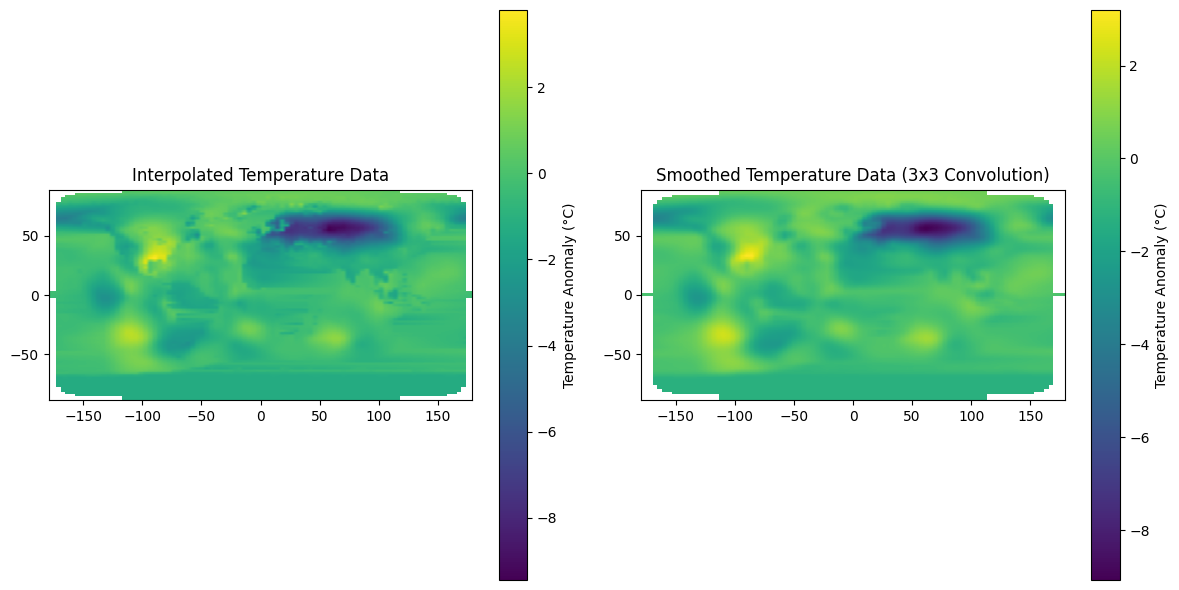

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# Define the 3x3 kernel for convolution
kernel_3x3 = np.array([[1/9, 1/9, 1/9],
                       [1/9, 1/9, 1/9],
                       [1/9, 1/9, 1/9]])

# Apply the 3x3 kernel convolution to the interpolated grid
temperature_grid_smoothed = convolve(temperature_grid, kernel_3x3, mode='nearest')

# Count the number of points originally and after smoothing
original_points = np.count_nonzero(~np.isnan(temperature_grid))
smoothed_points = np.count_nonzero(~np.isnan(temperature_grid_smoothed))

print(f"Puntos originales: {original_points}")
print(f"Puntos después del suavizado: {smoothed_points}")

# Plot the original interpolated temperature data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Interpolated Temperature Data")
plt.imshow(temperature_grid, extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], origin='lower')
plt.colorbar(label="Temperature Anomaly (°C)")

# Plot the smoothed temperature data after convolution
plt.subplot(1, 2, 2)
plt.title("Smoothed Temperature Data (3x3 Convolution)")
plt.imshow(temperature_grid_smoothed, extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], origin='lower')
plt.colorbar(label="Temperature Anomaly (°C)")

plt.tight_layout()
plt.show()


In [46]:
# Re-interpolate the data onto a regular grid for all time points
num_time_points = temperature_interpolated.shape[0]

# Initialize an array to hold the gridded temperature data over time
temperature_grid_over_time = np.empty((num_time_points, 90, 90))

# Interpolate for each time point
for t in range(num_time_points):
    temperature_grid_over_time[t] = griddata(
        (latitudes, longitudes), 
        temperature_interpolated[t], 
        (lat_grid_mesh, lon_grid_mesh), 
        method='linear'
    )

# Reshape the data for correlation calculation (each grid point as a "variable")
reshaped_temperature_data = temperature_grid_over_time.reshape(num_time_points, -1)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(reshaped_temperature_data.T)

# Check the shape and a sample of the correlation matrix
correlation_matrix_shape = correlation_matrix.shape
correlation_matrix_sample = correlation_matrix[:5, :5] 

correlation_matrix_shape, correlation_matrix_sample


((4050, 4050),
 array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]))

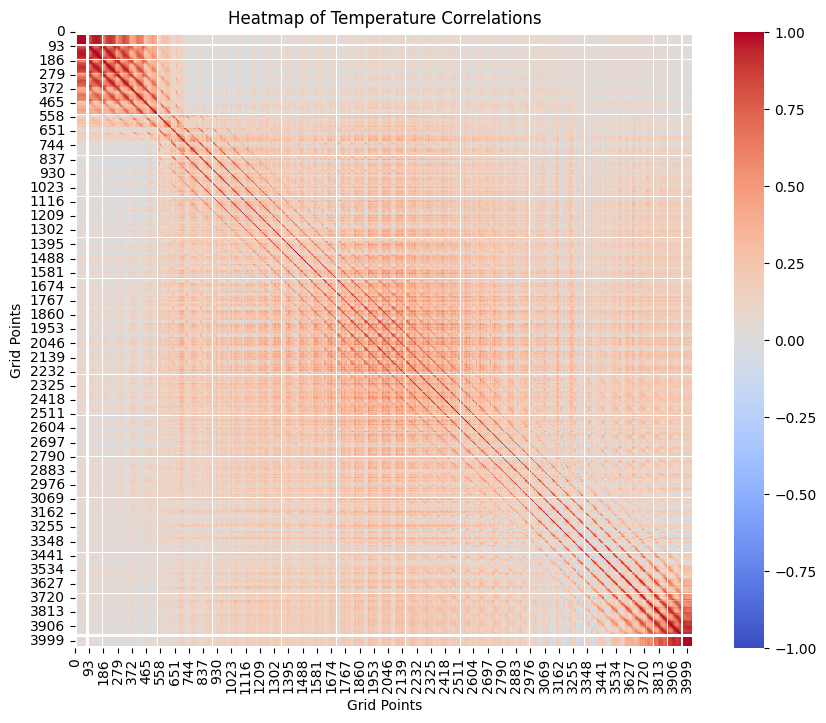

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap of Temperature Correlations")
plt.xlabel("Grid Points")
plt.ylabel("Grid Points")
plt.show()


In [54]:
# Reloading the necessary libraries and data
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns


times = data['time'].values

# Define the decades based on the time variable (assuming time is in years)
decades = np.floor(times / 10) * 10

# Initialize a dictionary to hold the correlation matrices by decade
correlation_matrices_by_decade = {}

# Process data by decade
unique_decades = np.unique(decades)

for decade in unique_decades:
    # Extract data for the current decade
    decade_mask = (decades == decade)
    temperature_decade = temperature[decade_mask, :]

    # Interpolate the data onto a regular grid for all time points in the decade
    num_time_points_decade = temperature_decade.shape[0]
    temperature_grid_over_time_decade = np.empty((num_time_points_decade, 90,90))
 
    for t in range(num_time_points_decade):
        temperature_grid_over_time_decade[t] = griddata(
            (latitudes, longitudes), 
            temperature_decade[t], 
            (lat_grid_mesh, lon_grid_mesh), 
            method='linear'
        )

    # Reshape the data for correlation calculation
    reshaped_temperature_data_decade = temperature_grid_over_time_decade.reshape(num_time_points_decade, -1)

    # Calculate the correlation matrix for this decade
    correlation_matrix_decade = np.corrcoef(reshaped_temperature_data_decade.T)
    
    # Store the correlation matrix
    correlation_matrices_by_decade[int(decade)] = correlation_matrix_decade

# Outputting the keys (decades) for confirmation
list(correlation_matrices_by_decade.keys())


[1850,
 1860,
 1870,
 1880,
 1890,
 1900,
 1910,
 1920,
 1930,
 1940,
 1950,
 1960,
 1970,
 1980,
 1990,
 2000,
 2010,
 2020]

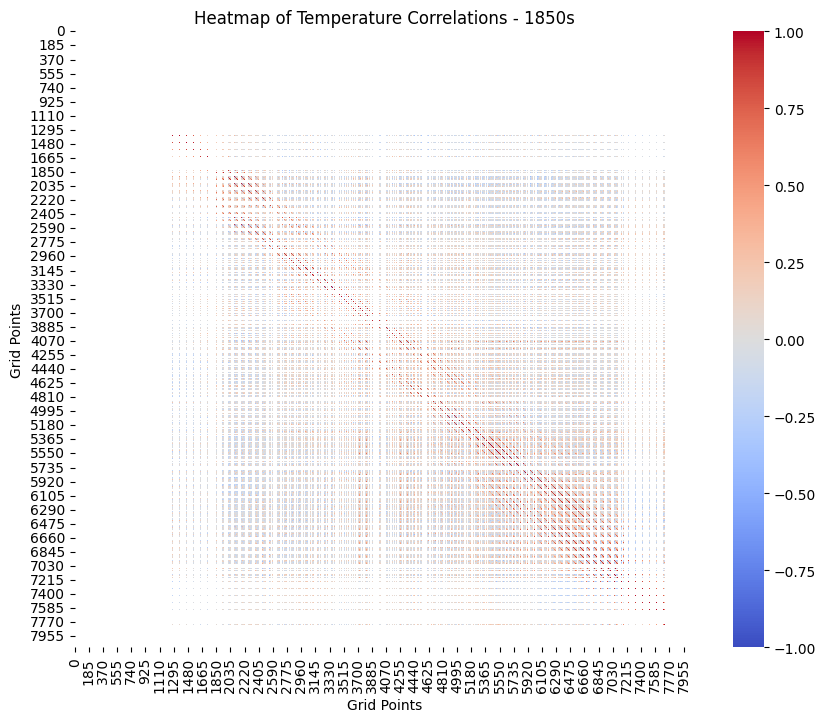

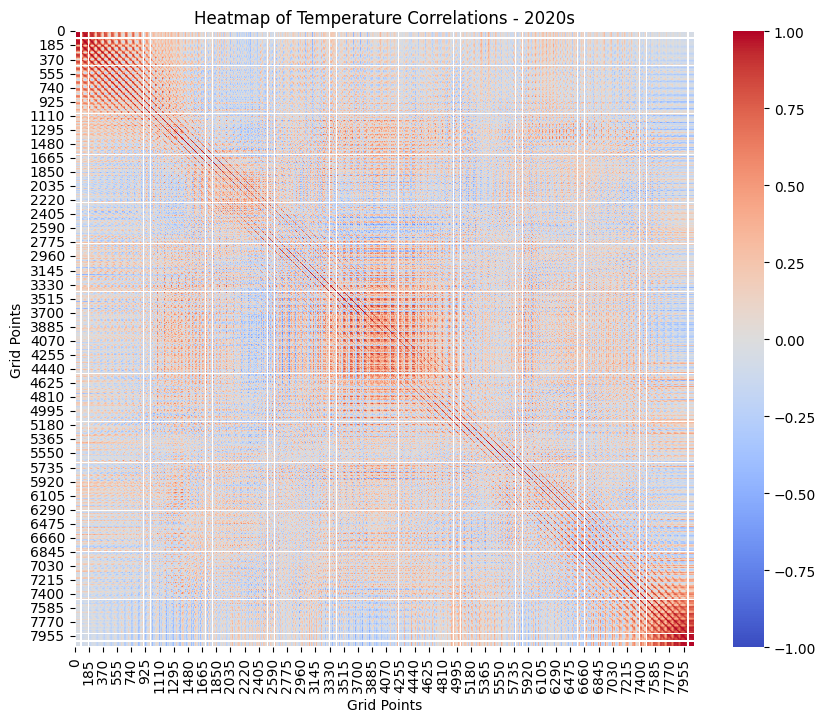

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las primeras y últimas décadas
first_decade = min(correlation_matrices_by_decade.keys())
last_decade = max(correlation_matrices_by_decade.keys())

# Mostrar el heatmap para la primera década
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrices_by_decade[first_decade], cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Heatmap of Temperature Correlations - {first_decade}s")
plt.xlabel("Grid Points")
plt.ylabel("Grid Points")
plt.show()

# Mostrar el heatmap para la última década
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrices_by_decade[last_decade], cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Heatmap of Temperature Correlations - {last_decade}s")
plt.xlabel("Grid Points")
plt.ylabel("Grid Points")
plt.show()


In [58]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Definir umbral de correlación significativa
correlation_threshold = 0.9

# Función para crear y visualizar la red con posiciones geográficas
def create_and_plot_geographical_network(corr_matrix, latitudes, longitudes, title):
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos (uno por cada punto en la cuadrícula)
    num_points = corr_matrix.shape[0]
    G.add_nodes_from(range(num_points))
    
    # Contar el número de nodos
    num_nodes = G.number_of_nodes()
    print(f"Número de nodos en la red: {num_nodes}")
    
    # Añadir enlaces (aristas) para correlaciones significativas
    for i in range(num_points):
        for j in range(i+1, num_points):
            if corr_matrix[i, j] > correlation_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Crear un diccionario de posiciones basado en las coordenadas geográficas
    pos = {i: (longitudes[i], latitudes[i]) for i in range(num_points)}
    
    # Dibujar la red
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='blue', edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Obtener las coordenadas geográficas interpoladas
lat_grid = np.linspace(latitudes.min(), latitudes.max(), 100)
lon_grid = np.linspace(longitudes.min(), longitudes.max(), 100)
lon_grid_mesh, lat_grid_mesh = np.meshgrid(lon_grid, lat_grid)

# Aplanar la malla para que coincida con la estructura de las matrices de correlación
flat_latitudes = lat_grid_mesh.flatten()
flat_longitudes = lon_grid_mesh.flatten()


Número de nodos en la red: 8100


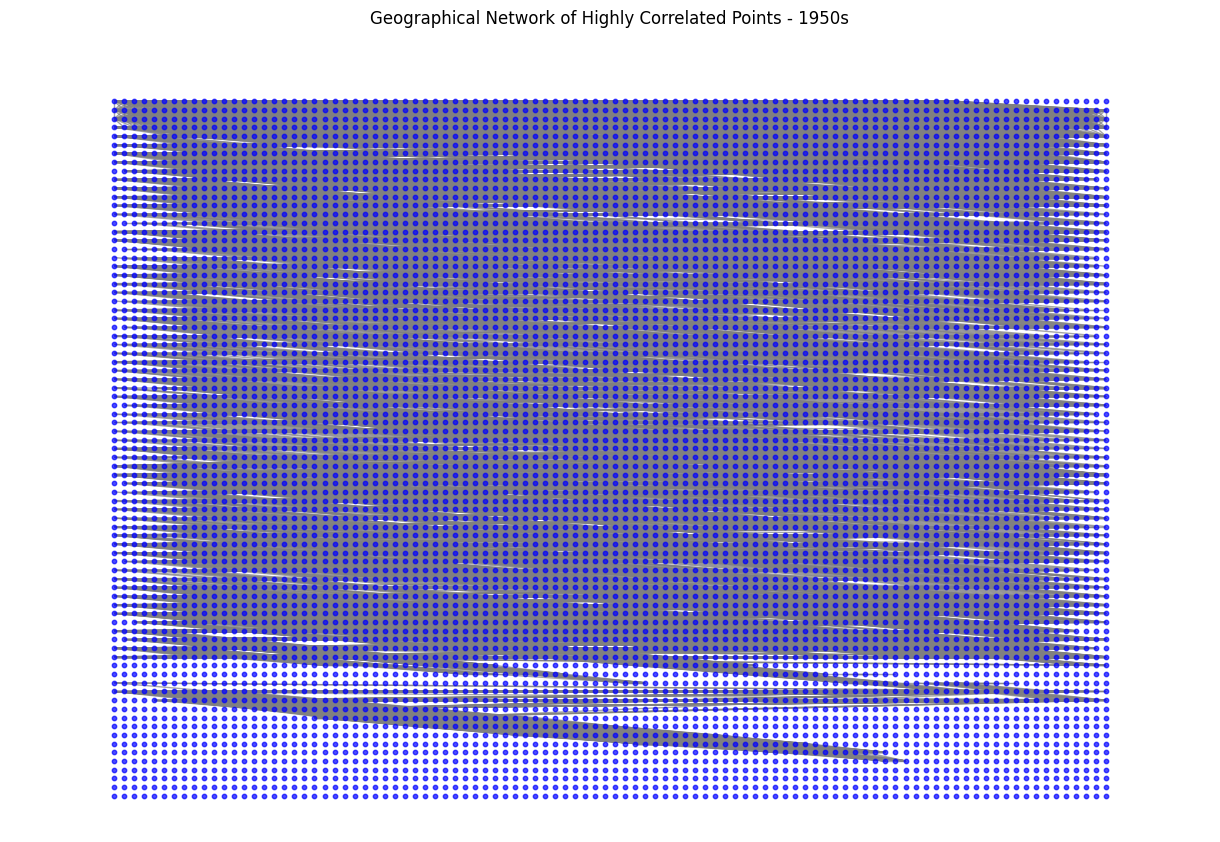

Número de nodos en la red: 8100


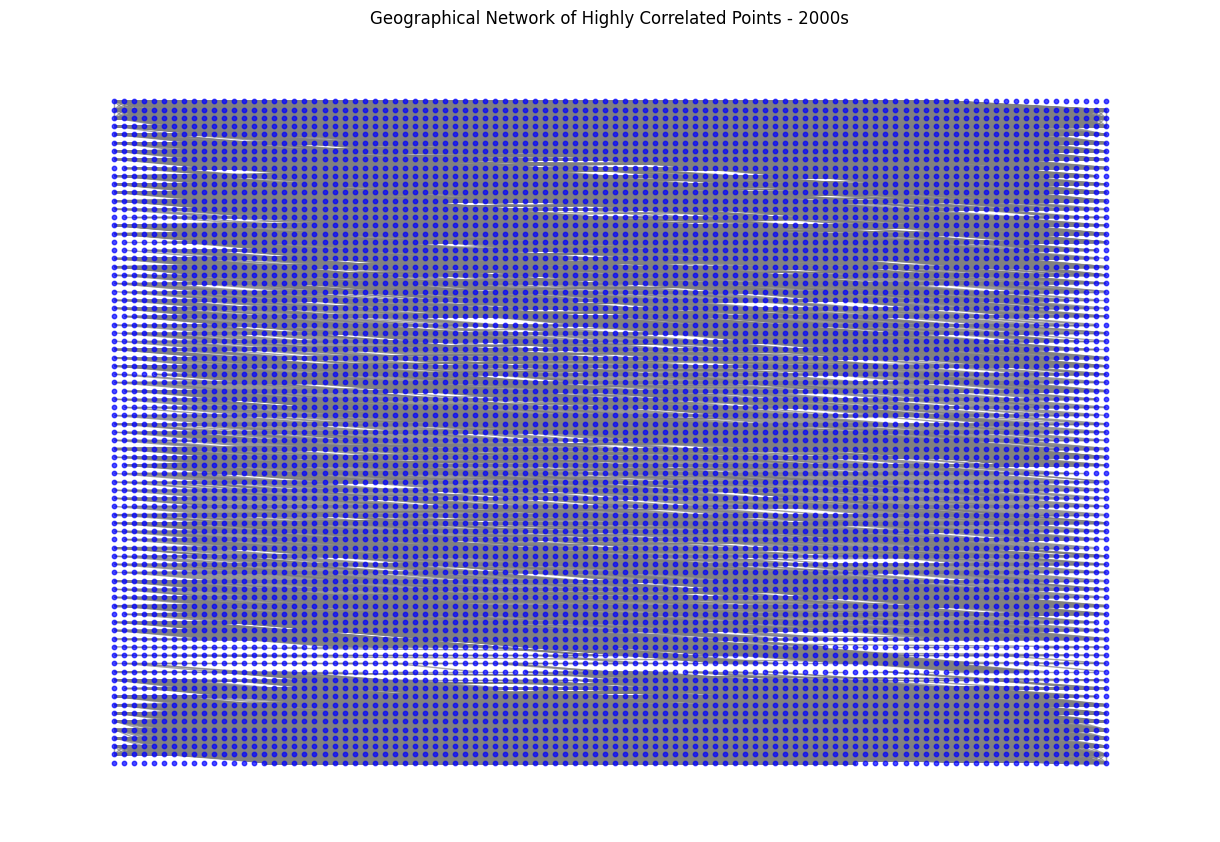

In [59]:
# Obtener las matrices de correlación específicas para las décadas de 1950 y 2000
# Aquí, "1950" y "2000" son los años de referencia para las respectivas décadas.
corr_matrix_1950 = correlation_matrices_by_decade[1950]
corr_matrix_2000 = correlation_matrices_by_decade[2000]

# Red para la década de 1950
create_and_plot_geographical_network(corr_matrix_1950, flat_latitudes, flat_longitudes, "Geographical Network of Highly Correlated Points - 1950s")

# Red para la década de 2000
create_and_plot_geographical_network(corr_matrix_2000, flat_latitudes, flat_longitudes, "Geographical Network of Highly Correlated Points - 2000s")

In [30]:
pip install python-louvain


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: C:\Users\danie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


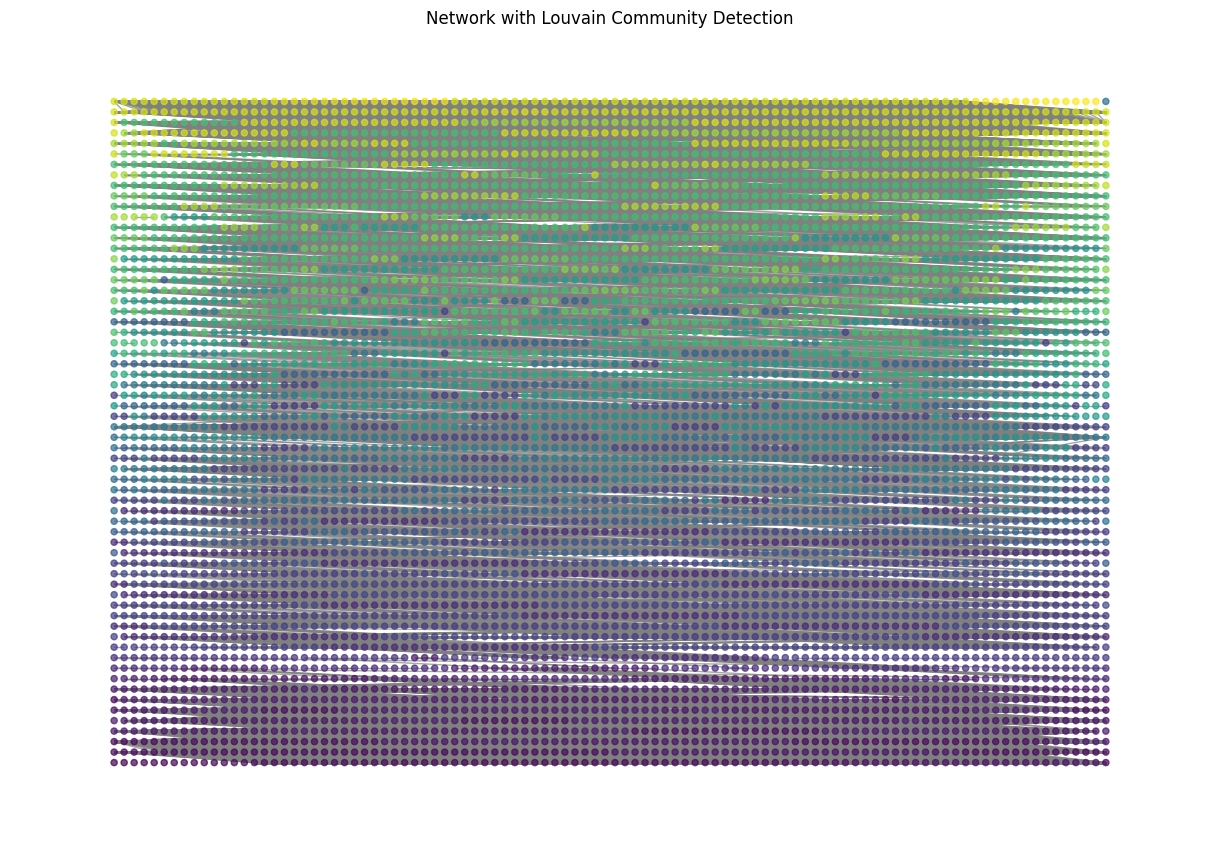

Número de comunidades detectadas: 721
Asignación de nodos a comunidades: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 14, 16: 14, 17: 14, 18: 14, 19: 14, 20: 14, 21: 14, 22: 14, 23: 14, 24: 14, 25: 14, 26: 14, 27: 14, 28: 14, 29: 14, 30: 14, 31: 14, 32: 14, 33: 14, 34: 14, 35: 14, 36: 14, 37: 14, 38: 14, 39: 14, 40: 14, 41: 14, 42: 14, 43: 14, 44: 14, 45: 14, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14, 54: 14, 55: 14, 56: 14, 57: 14, 58: 14, 59: 14, 60: 14, 61: 14, 62: 14, 63: 14, 64: 14, 65: 14, 66: 15, 67: 16, 68: 17, 69: 18, 70: 19, 71: 20, 72: 21, 73: 22, 74: 23, 75: 24, 76: 25, 77: 26, 78: 27, 79: 28, 80: 29, 81: 30, 82: 31, 83: 32, 84: 33, 85: 33, 86: 33, 87: 33, 88: 33, 89: 33, 90: 33, 91: 33, 92: 33, 93: 33, 94: 33, 95: 33, 96: 33, 97: 33, 98: 33, 99: 14, 100: 14, 101: 14, 102: 14, 103: 14, 104: 14, 105: 14, 106: 14, 107: 14, 108: 14, 109: 14, 110: 14, 111: 14, 112: 14, 113: 14, 114: 14, 115: 14, 11

In [33]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import community as community_louvain  # Importar el módulo community

# Definir umbral de correlación significativa
correlation_threshold = 0.9

# Función para crear y visualizar la red con posiciones geográficas y aplicar Louvain
def create_and_plot_geographical_network(corr_matrix, latitudes, longitudes, title):
    # Crear un grafo vacío
    G = nx.Graph()
    
    # Añadir nodos (uno por cada punto en la cuadrícula)
    num_points = corr_matrix.shape[0]
    G.add_nodes_from(range(num_points))
    
    # Añadir enlaces (aristas) para correlaciones significativas
    for i in range(num_points):
        for j in range(i+1, num_points):
            if corr_matrix[i, j] > correlation_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Crear un diccionario de posiciones basado en las coordenadas geográficas
    pos = {i: (longitudes[i], latitudes[i]) for i in range(num_points)}
    
    # Aplicar el algoritmo de Louvain para detectar comunidades
    partition = community_louvain.best_partition(G)
    
    # Dibujar la red con colores de nodos basados en la comunidad detectada
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap('viridis')
    nx.draw(G, pos, with_labels=False, node_size=20, node_color=list(partition.values()), cmap=cmap, edge_color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Mostrar las comunidades
    print("Número de comunidades detectadas:", len(set(partition.values())))
    print("Asignación de nodos a comunidades:", partition)

# Supongamos que tienes ya definidas `latitudes` y `longitudes`, y la matriz `corr_matrix`
# Ejemplo de uso de la función
create_and_plot_geographical_network(corr_matrix_2000, flat_latitudes, flat_longitudes, "Network with Louvain Community Detection")


<!-- Correlación con lag -->